In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


# NLP Data Preparation

In [3]:
# Reading the Data
train_raw_data = pd.read_excel("data/bank_a_sentiment_analysis_translated_inputdata.xlsx", engine = 'openpyxl')
validation_raw_data = pd.read_excel("data/bank_a_sentiment_analysis_translated_inputdata_unseen.xlsx", engine = 'openpyxl')

In [4]:
train_raw_data.head()

,review_id,translated_review,actual_sentiment
0,1,"in the branch of san marco evangelista, the em...",Positive
1,2,5 00 of commissions to withdraw your money at ...,Negative
2,3,when the f24 on the app thanks,Neutral
3,4,lower the commissions,Neutral
4,5,promotes and supports the small business in th...,Positive


In [5]:
validation_raw_data.head()

,review_id,translated_review,actual_sentiment
0,41,c always a little to fix,Neutral
1,44,there are multiple areas of improvement exampl...,Neutral
2,76,banca xxyyzz of valdengo to a great director,Positive
3,111,banca xxyyzz of valdengo to a great director,Negative
4,131,i lowered the votes given in previous evaluati...,Negative


In [6]:
print("Training Data shape",train_raw_data.shape)
print("Validation Data shape",validation_raw_data.shape)

Training Data shape (3486, 3)
Validation Data shape (200, 3)


In [7]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review_id          3486 non-null   int64 
 1   translated_review  3481 non-null   object
 2   actual_sentiment   3482 non-null   object
dtypes: int64(1), object(2)
memory usage: 81.8+ KB


In [8]:
validation_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review_id          200 non-null    int64 
 1   translated_review  200 non-null    object
 2   actual_sentiment   200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


In [9]:
# Check for Blank Records
train_raw_data[['translated_review','actual_sentiment']] = train_raw_data[['translated_review','actual_sentiment']].replace(r'^\s*$', np.nan, regex=True)
validation_raw_data[['translated_review','actual_sentiment']] = validation_raw_data[['translated_review','actual_sentiment']].replace(r'^\s*$', np.nan, regex=True)

In [10]:
train_raw_data.isna().sum(), validation_raw_data.isna().sum()

(review_id            0
 translated_review    5
 actual_sentiment     4
 dtype: int64,
 review_id            0
 translated_review    0
 actual_sentiment     0
 dtype: int64)

In [11]:
# Drop missing values and unique records
train_raw_data = train_raw_data.dropna(how = 'any')
print(train_raw_data.shape, train_raw_data.review_id.nunique())
print(validation_raw_data.shape, validation_raw_data.review_id.nunique())

(3477, 3) 3477
(200, 3) 200


In [12]:
# Drop special characters
def clean_special_chars(text):
    # Replace special characters with a space (or remove them by replacing with an empty string)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return text

train_raw_data['cleaned_review'] = train_raw_data['translated_review'].apply(clean_special_chars)
validation_raw_data['cleaned_review'] = validation_raw_data['translated_review'].apply(clean_special_chars)


In [13]:
#Stopwords removal and Lemmatization
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Tokenize and remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

train_raw_data['cleaned_review'] = train_raw_data['cleaned_review'].apply(clean_text)
validation_raw_data['cleaned_review'] = validation_raw_data['cleaned_review'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [14]:
#text length anomaly
train_raw_data['review_length'] = train_raw_data['translated_review'].str.len()
print("Training Data Review Length Statistics:")
print(train_raw_data['review_length'].describe())

validation_raw_data['review_length'] = validation_raw_data['translated_review'].str.len()
print("\nValidation Data Review Length Statistics:")
print(validation_raw_data['review_length'].describe())


Training Data Review Length Statistics:
count    3477.000000
mean       62.162784
std        69.053047
min         3.000000
25%        25.000000
50%        41.000000
75%        74.000000
max       750.000000
Name: review_length, dtype: float64

Validation Data Review Length Statistics:
count    200.000000
mean      56.010000
std       65.599362
min        6.000000
25%       24.750000
50%       42.500000
75%       66.250000
max      758.000000
Name: review_length, dtype: float64


In [15]:
# Example thresholds
min_length = 10
max_length = 110

train_raw_data = train_raw_data[train_raw_data['review_length'] > min_length]
train_raw_data = train_raw_data[train_raw_data['review_length'] < max_length]

validation_raw_data = validation_raw_data[validation_raw_data['review_length'] > min_length]
validation_raw_data = validation_raw_data[validation_raw_data['review_length'] < max_length]


In [16]:
#prepared dataset
train_raw_data['review_length'] = train_raw_data['translated_review'].str.len()
print("Training Data Review Length Statistics:")
print(train_raw_data['review_length'].describe())

validation_raw_data['review_length'] = validation_raw_data['translated_review'].str.len()
print("\nValidation Data Review Length Statistics:")
print(validation_raw_data['review_length'].describe())

Training Data Review Length Statistics:
count    2896.000000
mean       43.545925
std        24.058563
min        11.000000
25%        25.000000
50%        37.000000
75%        58.000000
max       109.000000
Name: review_length, dtype: float64

Validation Data Review Length Statistics:
count    177.000000
mean      44.824859
std       23.872718
min       11.000000
25%       26.000000
50%       41.000000
75%       64.000000
max      103.000000
Name: review_length, dtype: float64


# EDA

In [17]:
train_raw_data.describe(include = ['object'])

,translated_review,actual_sentiment,cleaned_review
count,2896,2896,2896
unique,2764,3,2632
top,because i am fine,Positive,fine
freq,11,1606,12


In [18]:
# Display the first few reviews
print(train_raw_data['cleaned_review'].head())


1      commission withdraw money counter theft
2                                 f app thanks
3                             lower commission
4    promotes support small business territory
5      add name company prematarcored bulletin
Name: cleaned_review, dtype: object


In [19]:
# Sentiment Distribution across Reviews
train_raw_data.actual_sentiment.value_counts()

Positive    1606
Neutral      879
Negative     411
Name: actual_sentiment, dtype: int64

In [20]:
# hypothesis - generally negative reviews does have higher word count
# Average Word Count across different types of Sentiment
def get_word_count(x):
    return len(x.split(" "))
train_raw_data['Word Count'] = train_raw_data['translated_review'].map(get_word_count)

In [21]:
train_raw_data.groupby('actual_sentiment').agg({'Word Count':['mean','median']}).reset_index()

actual_sentiment Word Count       
                         mean median
0         Negative   8.447689    7.0
1          Neutral   7.226394    6.0
2         Positive   6.991905    6.0

<Axes: xlabel='Word Count', ylabel='Density'>

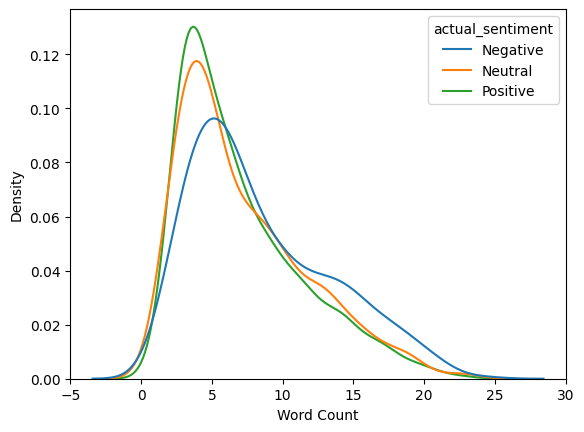

In [22]:
import scipy
sns.kdeplot(data = train_raw_data, x = 'Word Count', hue = 'actual_sentiment',
           common_norm=False)

In [23]:
train_raw_data.head()

,review_id,translated_review,actual_sentiment,cleaned_review,review_length,Word Count
1,2,5 00 of commissions to withdraw your money at ...,Negative,commission withdraw money counter theft,65,13
2,3,when the f24 on the app thanks,Neutral,f app thanks,30,7
3,4,lower the commissions,Neutral,lower commission,21,3
4,5,promotes and supports the small business in th...,Positive,promotes support small business territory,57,9
5,6,add more names of companies to prematarcored b...,Neutral,add name company prematarcored bulletin,54,8


# Check for Blank Reviews After processing the Data

In [24]:
# Remove Blank Reviews
train_raw_data.dropna(subset=["cleaned_review"], inplace=True)

In [25]:
train_raw_data.describe(include = ['object'])

,translated_review,actual_sentiment,cleaned_review
count,2896,2896,2896
unique,2764,3,2632
top,because i am fine,Positive,fine
freq,11,1606,12


In [26]:
# Analyse duplicates reviews
duplicated = train_raw_data[train_raw_data.duplicated(subset = ['cleaned_review'], keep = False)]
same_review_diff_sentiment = duplicated.groupby('cleaned_review').agg({'actual_sentiment':'nunique',
                                                                                   'review_id':'nunique'}).reset_index()
same_review_diff_sentiment = same_review_diff_sentiment[same_review_diff_sentiment['actual_sentiment'] > 1]
same_review_diff_sentiment.shape

(79, 3)

In [27]:
duplicated[duplicated['cleaned_review'].isin(same_review_diff_sentiment['cleaned_review'])].sort_values(
    by = ['cleaned_review']).head(10)

,review_id,translated_review,actual_sentiment,cleaned_review,review_length,Word Count
1969,2090,i am always available,Positive,always available,21,4
1938,2056,always available,Positive,always available,16,2
3115,3289,because it is always available,Neutral,always available,30,5
1547,1644,always available,Positive,always available,16,2
2098,2225,you are always available,Positive,always available,24,4
1208,1282,always available,Neutral,always available,16,2
995,1057,not always available,Negative,always available,20,3
3129,3304,i have always found myself well,Neutral,always found well,31,6
2101,2228,because i have always found myself well,Neutral,always found well,39,7
1563,1660,because i have always found myself well,Positive,always found well,39,7


In [28]:
# Remove Records where same processed review have multiple sentiment.
train_raw_data = train_raw_data[~train_raw_data.duplicated(subset = ['cleaned_review'], keep = False)]
train_raw_data.shape

(2503, 6)

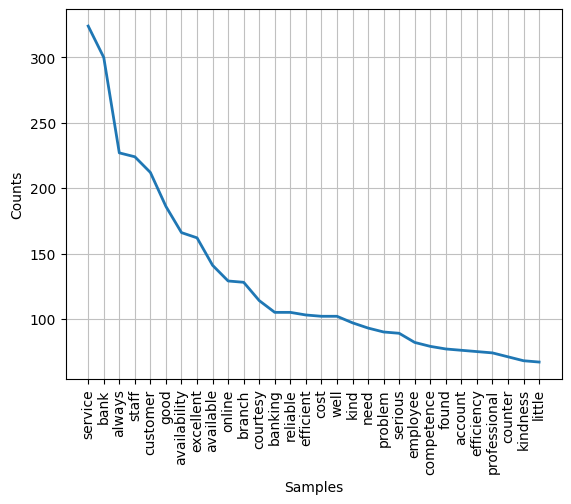

<Axes: xlabel='Samples', ylabel='Counts'>

In [29]:
all_keywords = ' '.join(train_raw_data['cleaned_review']).split()
keyword_freq = nltk.FreqDist(all_keywords)
keyword_freq.plot(30)

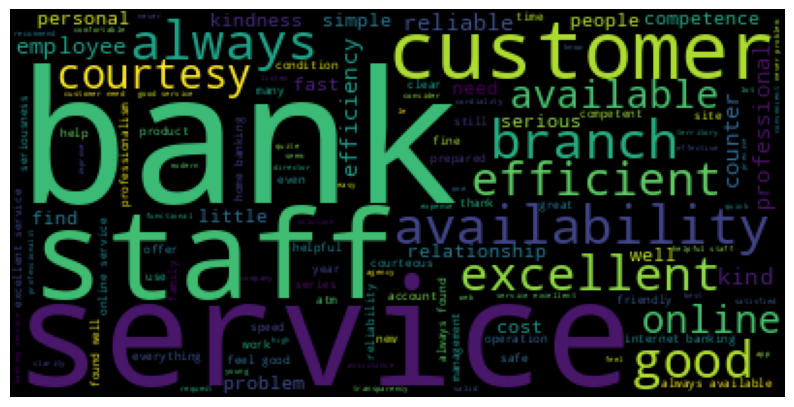

In [30]:
cloud = WordCloud()
cloud = cloud.generate(' '.join(train_raw_data['cleaned_review']))
plt.figure(figsize=(10,15))
plt.imshow(cloud)
plt.axis('off');

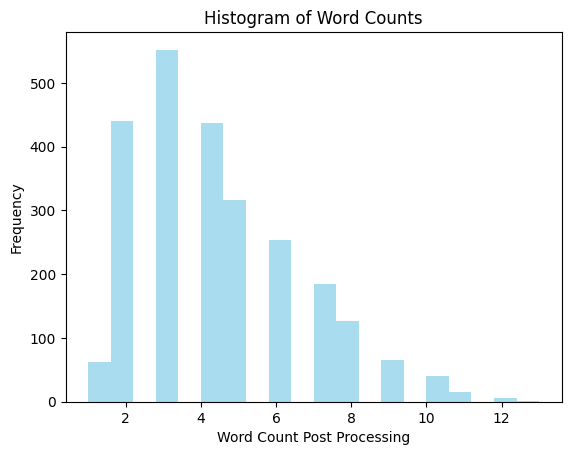

In [31]:
def analyze_word_counts(df):
    df['word_count_post_processing'] = df['cleaned_review'].apply(lambda x: len(x.split()))
    plt.hist(df['word_count_post_processing'], bins=20, color='skyblue', alpha=0.7)
    plt.xlabel('Word Count Post Processing')
    plt.ylabel('Frequency')
    plt.title('Histogram of Word Counts')
    plt.show()
analyze_word_counts(train_raw_data)

# Word Count Post and Pre-Processing Comparison

In [32]:
train_raw_data['Word_Count_Difference'] = train_raw_data['Word Count'] - train_raw_data['word_count_post_processing']
# Check that Post Processing word Count will be >= 0
print("Reviews where the Post Processing Word Count has increased",train_raw_data[train_raw_data['Word_Count_Difference']<0].shape)

Reviews where the Post Processing Word Count has increased (0, 8)


In [33]:
print("Number of Review where words have been removed as part of the data processing is {} out of {}".\
      format(train_raw_data[train_raw_data['Word_Count_Difference']>0].shape[0], train_raw_data.shape[0]))

Number of Review where words have been removed as part of the data processing is 2211 out of 2503


# Sentiment vs Word Count Post Processing

In [34]:
train_raw_data.groupby('actual_sentiment').agg({'word_count_post_processing':['mean','median']}).reset_index()

actual_sentiment word_count_post_processing       
                                         mean median
0         Negative                   4.631443    4.0
1          Neutral                   4.419486    4.0
2         Positive                   4.321948    4.0

<Axes: xlabel='word_count_post_processing', ylabel='Density'>

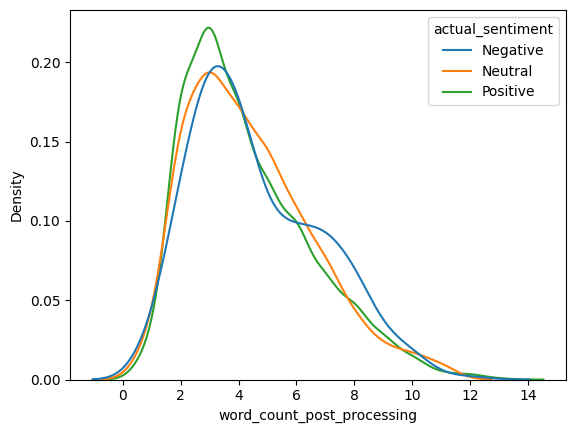

In [35]:
import scipy
sns.kdeplot(data = train_raw_data, x = 'word_count_post_processing', hue = 'actual_sentiment',
           common_norm=False)

In [36]:
#understanding words in overall reviews
from collections import Counter

# Tokenize the reviews and count the occurrences of each word
all_words = ' '.join(train_raw_data['cleaned_review']).split()
word_freq = Counter(all_words)

# Display the most common words
print(word_freq.most_common(10))



[('service', 324), ('bank', 300), ('always', 227), ('staff', 224), ('customer', 212), ('good', 186), ('availability', 166), ('excellent', 162), ('available', 141), ('online', 129)]


In [37]:
train_raw_data.head(10)

,review_id,translated_review,actual_sentiment,cleaned_review,review_length,Word Count,word_count_post_processing,Word_Count_Difference
1,2,5 00 of commissions to withdraw your money at ...,Negative,commission withdraw money counter theft,65,13,5,8
2,3,when the f24 on the app thanks,Neutral,f app thanks,30,7,3,4
3,4,lower the commissions,Neutral,lower commission,21,3,2,1
4,5,promotes and supports the small business in th...,Positive,promotes support small business territory,57,9,5,4
5,6,add more names of companies to prematarcored b...,Neutral,add name company prematarcored bulletin,54,8,5,3
7,8,even if i liked the old site more i must say t...,Positive,even liked old site must say among best among ...,94,22,12,10
11,12,"and to measure from men and company, even a sm...",Positive,measure men company even small company,57,11,6,5
12,13,Rossella ohara at the pavia and fantastic branch,Positive,Rossella ohara pavia fantastic branch,48,8,5,3
13,14,open a branch in trecate,Neutral,open branch trecate,24,5,3,2
14,15,happy new year taldeital,Neutral,happy new year taldeital,24,4,4,0


# Build Models

In [38]:
#word2vec vectorization
from gensim.models import Word2Vec

# Tokenize the reviews
sentences = train_raw_data['cleaned_review'].apply(lambda x: x.split()).tolist()

# Train a Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.save("word2vec.model")

# Convert reviews to vectors
def review_to_vec(review, model):
    tokens = review.split()
    vec = np.mean([model.wv[token] for token in tokens if token in model.wv], axis=0)
    return vec

train_raw_data['w2v_vector'] = train_raw_data['cleaned_review'].apply(lambda x: review_to_vec(x, w2v_model))



In [39]:
#TFIDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 most frequent words
X_tfidf = tfidf_vectorizer.fit_transform(train_raw_data['cleaned_review']).toarray()



In [40]:
from sklearn.model_selection import train_test_split

# For Word2Vec
X_w2v = np.array(train_raw_data['w2v_vector'].tolist())
y = train_raw_data['actual_sentiment']
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

# For TF-IDF
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# For Word2Vec
clf_rf_w2v = RandomForestClassifier(n_estimators=100)
clf_rf_w2v.fit(X_train_w2v, y_train_w2v)
y_pred_w2v = clf_rf_w2v.predict(X_test_w2v)
print("Word2Vec with RandomForest:")
print(classification_report(y_test_w2v, y_pred_w2v))

# For TF-IDF
clf_rf_tfidf = RandomForestClassifier(n_estimators=100)
clf_rf_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = clf_rf_tfidf.predict(X_test_tfidf)
print("TF-IDF with RandomForest:")
print(classification_report(y_test_tfidf, y_pred_tfidf))


Word2Vec with RandomForest:
              precision    recall  f1-score   support

    Negative       0.35      0.09      0.14        78
     Neutral       0.33      0.11      0.17       142
    Positive       0.59      0.91      0.72       281

    accuracy                           0.55       501
   macro avg       0.42      0.37      0.34       501
weighted avg       0.48      0.55      0.47       501

TF-IDF with RandomForest:
              precision    recall  f1-score   support

    Negative       0.72      0.29      0.42        78
     Neutral       0.32      0.15      0.21       142
    Positive       0.61      0.87      0.72       281

    accuracy                           0.58       501
   macro avg       0.55      0.44      0.45       501
weighted avg       0.55      0.58      0.53       501



In [42]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Now split the data again with the encoded labels
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_encoded, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

# Train XGBoost again

# For Word2Vec
clf_xgb_w2v = xgb.XGBClassifier()
clf_xgb_w2v.fit(X_train_w2v, y_train_w2v)
y_pred_w2v_xgb = clf_xgb_w2v.predict(X_test_w2v)

# Convert predictions back to original labels for evaluation
y_pred_w2v_xgb_labels = label_encoder.inverse_transform(y_pred_w2v_xgb)
y_test_w2v_labels = label_encoder.inverse_transform(y_test_w2v)

print("Word2Vec with XGBoost:")
print(classification_report(y_test_w2v_labels, y_pred_w2v_xgb_labels))

# For TF-IDF
clf_xgb_tfidf = xgb.XGBClassifier()
clf_xgb_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf_xgb = clf_xgb_tfidf.predict(X_test_tfidf)

# Convert predictions back to original labels for evaluation
y_pred_tfidf_xgb_labels = label_encoder.inverse_transform(y_pred_tfidf_xgb)
y_test_tfidf_labels = label_encoder.inverse_transform(y_test_tfidf)

print("TF-IDF with XGBoost:")
print(classification_report(y_test_tfidf_labels, y_pred_tfidf_xgb_labels))



Word2Vec with XGBoost:
              precision    recall  f1-score   support

    Negative       0.38      0.14      0.21        78
     Neutral       0.33      0.24      0.28       142
    Positive       0.62      0.81      0.70       281

    accuracy                           0.54       501
   macro avg       0.44      0.40      0.39       501
weighted avg       0.50      0.54      0.50       501

TF-IDF with XGBoost:
              precision    recall  f1-score   support

    Negative       0.51      0.24      0.33        78
     Neutral       0.38      0.25      0.30       142
    Positive       0.65      0.85      0.74       281

    accuracy                           0.59       501
   macro avg       0.51      0.45      0.45       501
weighted avg       0.55      0.59      0.55       501



# Using Pre-Trained models

In [43]:
#TextBlob model
from textblob import TextBlob

def textblob_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

train_raw_data['textblob_prediction'] = train_raw_data['cleaned_review'].apply(textblob_sentiment)


In [44]:
!pip install transformers
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 3.8 MB/s eta 0:00:00


In [45]:
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:  # Fix is here
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)


In [50]:
#VanderSentiment model
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    vs = analyzer.polarity_scores(text)
    if vs['compound'] >= 0.05:
        return 'Positive'
    elif vs['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

train_raw_data['vader_prediction'] = train_raw_data['translated_review'].apply(vader_sentiment)


In [55]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np

# Assuming your raw data is in a DataFrame called 'data' and the sentiments are in a column called 'actual_sentiment'
train_raw_data, validation_raw_data_stratified = train_test_split(train_raw_data, test_size=0.2, stratify=train_raw_data['actual_sentiment'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train_raw_data['actual_sentiment'])

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels).to(device)

# Tokenize the training data
train_encodings = tokenizer(train_raw_data['translated_review'].tolist(), truncation=True, padding=True, max_length=512)
train_labels = label_encoder.transform(train_raw_data['actual_sentiment'])
train_dataset = SentimentDataset(train_encodings, train_labels)

# Tokenize the stratified validation data
validation_encodings_stratified = tokenizer(validation_raw_data_stratified['translated_review'].tolist(), truncation=True, padding=True, max_length=512)
validation_dataset_stratified = SentimentDataset(validation_encodings_stratified, label_encoder.transform(validation_raw_data_stratified['actual_sentiment']))

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./bertmodel',
    num_train_epochs=2,
    per_device_train_batch_size=3,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    learning_rate=2e-5,
    gradient_accumulation_steps=2,
    save_strategy="epoch",
    save_total_limit=2,  # Only keep the last 2 models to save space
    evaluation_strategy="epoch",
)

# Modify the Trainer instantiation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset_stratified  # Using the stratified validation set
)

# Train the model
trainer.train()

# Predict using the original validation set
validation_encodings = tokenizer(validation_raw_data['translated_review'].tolist(), truncation=True, padding=True, max_length=512)
validation_predictions = trainer.predict(SentimentDataset(validation_encodings))
validation_predicted_labels = label_encoder.inverse_transform(np.argmax(validation_predictions.predictions, axis=1))
validation_raw_data['bert_prediction'] = validation_predicted_labels


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,1.001300,0.885319
1,0.790000,0.778613


In [ ]:
#Using bert model on the actual translated_review as it learns the context
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train_raw_data['actual_sentiment'])
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels).to(device)


# Tokenize the training data
train_encodings = tokenizer(train_raw_data['translated_review'].tolist(), truncation=True, padding=True, max_length=512)
train_labels = label_encoder.transform(train_raw_data['actual_sentiment'])
train_dataset = SentimentDataset(train_encodings, train_labels)

# Tokenize the validation data
validation_encodings = tokenizer(validation_raw_data['translated_review'].tolist(), truncation=True, padding=True, max_length=512)
assert len(train_encodings['input_ids']) == len(train_labels)


# Define the training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./bertmodel',
    num_train_epochs=3,
    per_device_train_batch_size=3,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    learning_rate=2e-5,
    gradient_accumulation_steps=2,
    save_strategy="epoch",
    save_total_limit=2,  # Only keep the last 2 models to save space
      # Load the best model in terms of evaluation metric at the end of training
)


# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,

)

# Train the model
trainer.train()

# Predict
validation_predictions = trainer.predict(SentimentDataset(validation_encodings))
validation_predicted_labels = label_encoder.inverse_transform(np.argmax(validation_predictions.predictions, axis=1))

validation_raw_data['bert_prediction'] = validation_predicted_labels



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,1.067700
200,0.964300
300,0.848500
400,0.790600
500,0.790300
600,0.742000
700,0.716800
800,0.683100
900,0.655400
1000,0.565700


In [53]:
validation_raw_data['textblob_prediction'] = validation_raw_data['cleaned_review'].apply(textblob_sentiment)
validation_raw_data['vader_prediction'] = validation_raw_data['translated_review'].apply(vader_sentiment)

In [56]:
from sklearn.metrics import accuracy_score, f1_score

# TextBlob
accuracy_textblob = accuracy_score(validation_raw_data['actual_sentiment'], validation_raw_data['textblob_prediction'])
f1_textblob = f1_score(validation_raw_data['actual_sentiment'], validation_raw_data['textblob_prediction'], average='weighted')

# VaderSentiment
accuracy_vader = accuracy_score(validation_raw_data['actual_sentiment'], validation_raw_data['vader_prediction'])
f1_vader = f1_score(validation_raw_data['actual_sentiment'], validation_raw_data['vader_prediction'], average='weighted')

# BERT
accuracy_bert = accuracy_score(validation_raw_data['actual_sentiment'], validation_raw_data['bert_prediction'])
f1_bert = f1_score(validation_raw_data['actual_sentiment'], validation_raw_data['bert_prediction'], average='weighted')

print("Model Evaluation:")
print(f"TextBlob - Accuracy: {accuracy_textblob}, F1-score: {f1_textblob}")
print(f"VaderSentiment - Accuracy: {accuracy_vader}, F1-score: {f1_vader}")
print(f"BERT - Accuracy: {accuracy_bert}, F1-score: {f1_bert}")


Model Evaluation:
TextBlob - Accuracy: 0.4745762711864407, F1-score: 0.4769104934654796
VaderSentiment - Accuracy: 0.5875706214689266, F1-score: 0.5653906798210538
BERT - Accuracy: 0.672316384180791, F1-score: 0.6713723631502102


In [57]:
scores = {
    'TextBlob': f1_textblob,
    'VaderSentiment': f1_vader,
    'BERT': f1_bert
}

best_model = max(scores, key=scores.get)

print(f"The best model for sentiment analysis based on the F1-score is: {best_model} with an F1-score of {scores[best_model]}")


The best model for sentiment analysis based on the F1-score is: BERT with an F1-score of 0.6713723631502102
